Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection, metrics

Loading the dataset

In [2]:
data = pd.read_csv("data/CO2 Emissions_Canada.csv")
trans_df = pd.read_csv("data/transmission_codes_full.csv")
code_map = dict(zip(trans_df["trans_code"], trans_df["trans_description"]))

In [4]:
print(data.dtypes)

Make                                 object
Model                                object
Vehicle Class                        object
Engine Size(L)                      float64
Cylinders                             int64
Transmission                         object
Fuel Type                            object
Fuel Consumption City (L/100 km)    float64
Fuel Consumption Hwy (L/100 km)     float64
Fuel Consumption Comb (L/100 km)    float64
Fuel Consumption Comb (mpg)           int64
CO2 Emissions(g/km)                   int64
dtype: object


Data cleaning and engeenering

In [27]:
non_informative_columns = ["Make", "Model"]
redundant_columns = ["Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
# The producer can't know fuel consumption in advance.
# It can only be mesured after the car is built.
leakage_variables = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)"]
columns_to_drop = non_informative_columns + redundant_columns + leakage_variables
data.drop(columns=columns_to_drop, inplace=True)
data.isna().sum()

Vehicle Class          0
Engine Size(L)         0
Cylinders              0
Transmission           0
Fuel Type              0
CO2 Emissions(g/km)    0
dtype: int64

Transform transmision code classes into readable ones

In [28]:
trans_split = data["Transmission"].astype(str).str.extract(
    r'^(?P<code>[A-Z]+)(?P<gears>\d*)$'
)
desc = trans_split["code"].map(code_map)
# Fall back to the original if some codes are missing
desc = desc.fillna(trans_split["code"])
gears = trans_split["gears"]
data["Transmission_full"] = np.where(
    gears.notna() & (gears != ""),
    desc + " (" + gears + " gears)",
    desc
)
data["Transmission"] = data["Transmission_full"]
data.drop(columns=["Transmission_full"], inplace=True)

data[["Transmission"]].head()

,Transmission
0,Automatic with select shift (5 gears)
1,Manual (6 gears)
2,Continuously variable (7 gears)
3,Automatic with select shift (6 gears)
4,Automatic with select shift (6 gears)


Transform fuel type classes into readable ones

In [29]:
fuel_df = pd.read_csv("data/fuel_codes.csv")
fuel_map = dict(zip(fuel_df["fuel_code"], fuel_df["fuel_description"]))
fuel_desc = data["Fuel Type"].map(fuel_map)
# Fall back to original code if no match is found
fuel_desc = fuel_desc.fillna(data["Fuel Type"])
data["Fuel Type_full"] = fuel_desc
data["Fuel Type"] = fuel_desc
data.drop(columns=["Fuel Type_full"], inplace=True)

print(data[["Fuel Type"]].head())

          Fuel Type
0  Premium gasoline
1  Premium gasoline
2  Premium gasoline
3  Premium gasoline
4  Premium gasoline


## 1️⃣❓ <span style="color:#e63946;">Choose a quantitative variable that your model will try to predict, and use the rest of the variables to train the model</span><br>
<span style="color:#ffb703;"><i> Automakers worldwide face increasing pressure to reduce vehicle emissions to meet environmental regulations and consumer demand for greener cars. This project aims to provide a data-driven tool for predicting CO₂ output based on pre-production vehicle specifications.</i></span>

<span style="color:#ffb703;"><i>
By inputting design features (like engine size, fuel type, number of cylinders, etc.), engineers can:
</i></span><br>
<ul style="color:#ffb703; font-style:italic;">
  <li>Estimate emissions before production</li>
  <li>Experiment with different design choices</li>
  <li>Optimize for lower emissions</li>
  <li>Accelerate eco-conscious decision-making</li>
</ul>

#### <span style="color:#2a9d8f;"><b>So, the decision is to predict CO₂ emission</b></span>

Choose the y variable output (all other variables are used as input), as well as the `test_size`, `random_state`, and `alpha`

## 2️⃣❓ <span style="color:#e63946;">Use an 80/20 train/test split for your data.</span>
#### <span style="color:#2a9d8f;"><b>↓↓↓</b></span>

In [30]:
y_column = "CO2 Emissions(g/km)"
test_size = 0.2
random_state = 123

The data is divided into training and test sets:

In [31]:
X = data.drop(y_column, axis=1)
X = pd.get_dummies(X)
y = data[[y_column]]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=random_state)

## ❓ <span style="color:#e63946;"><b>Train Lasso regression models using different values of alpha (the regularization parameter).</b></span><br>

In [32]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

train_r2_scores, test_r2_scores = [], []
best_alpha = None
best_r2 = -np.inf

for alpha in alpha_values:
    reg = linear_model.Lasso(alpha=alpha, max_iter=50000, random_state=random_state)
    reg.fit(X_train, y_train)
    
    train_r2 = reg.score(X_train, y_train)
    test_r2 = reg.score(X_test, y_test)
    
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
    print(f"Alpha={alpha:<7} | Train R²={train_r2:.3f} | Test R²={test_r2:.3f}")
    
    r2_is_better = round(test_r2, 3) > round(best_r2, 3)
    r2_equal_but_alpha_larger = (
        round(test_r2, 3) == round(best_r2, 3)
        and (best_alpha is None or alpha > best_alpha)
    )
    if r2_is_better or r2_equal_but_alpha_larger:
        best_r2 = test_r2
        best_alpha = alpha
        best_reg = reg
        best_y_test_pred = reg.predict(X_test)

print(f"\n✅ Best alpha: {best_alpha:.4f} (Test R² = {best_r2:.3f})")

Alpha=0.0001  | Train R²=0.856 | Test R²=0.842
Alpha=0.001   | Train R²=0.856 | Test R²=0.842
Alpha=0.01    | Train R²=0.856 | Test R²=0.841
Alpha=0.1     | Train R²=0.849 | Test R²=0.833
Alpha=1.0     | Train R²=0.768 | Test R²=0.753
Alpha=10.0    | Train R²=0.720 | Test R²=0.702

✅ Best alpha: 0.0010 (Test R² = 0.842)


<span style="color:#ffb703;"><i>a. Record each alpha value tested, along with the corresponding training R² and test R² scores.</i></span>

<span style="color:#2a9d8f;">
  
| `Alpha (α)` | Training R² | Test R² |
| -- | -- | -- |
| 0.0001 | 0.856 | 0.842 |
| 0.001 | 0.856 | 0.842 |
| 0.01 | 0.856 | 0.841 |
| 0.1 | 0.849 | 0.833 |
| 1.0 | 0.768 | 0.753 |
| 10.0 | 0.720 | 0.702 |

</span>

<span style="color:#ffb703;"><i>
b. Identify the alpha value that gives the highest test R² score.
</i></span><br><br>

#### <span style="color:#2a9d8f;"><b>✅ The best-performing alpha is <code>0.001</code>, with Test R² = 0.842.</b></span>

## 4️⃣❓ <span style="color:#e63946;"><b> What is the test RMSE for the best-performing model? What is your interpretation of this value?</b></span><br>

In [33]:
best_alpha = alpha_values[1]

test_rmse = metrics.root_mean_squared_error(y_test, best_y_test_pred)

print(f"\n✅ For the best performing alpha = 0.001")
print(f"Test RMSE = {test_rmse:.3f} (g/km)")


✅ For the best performing alpha = 0.001
Test RMSE = 23.633 (g/km)


#### <span style="color:#2a9d8f;"><b>✅ Interpretation: This means that, on average, the model's predictions of CO₂ emissions differ from the actual values by about 23.633 grams of CO₂ per kilometer.</b>

## 5️⃣❓ <span style="color:#e63946;"><b>Discuss whether your model seems to be overfitting or underfitting for any of the values of alpha you tested in part (c). How does the model’s performance change as alpha increases or decreases?</b></span><br>


<span style="color:#2a9d8f;"><i>
For very small α values (0.0001–0.01), the model achieves its highest and most balanced performance, with Train and Test R² scores remaining almost identical (≈0.856 vs. 0.842).  
This indicates that the model generalizes well and does not overfit within this range.
</i></span><br><br>
<span style="color:#2a9d8f;"><i>
When α increases beyond 0.01, both the Train and Test R² scores start to decline noticeably.  
For example, at α = 1.0, the Train R² drops to 0.768 and the Test R² to 0.753, showing that the model has become too constrained and is no longer fitting the training data adequately — a sign of **underfitting** due to excessive regularization.
</i></span><br><br>
<span style="color:#2a9d8f;"><i>
In contrast, when α is very small (close to zero), the regularization effect is minimal, and the model captures nearly all linear relationships in the data without overfitting.  
Thus, α = 0.001 represents an optimal balance between bias and variance: it maintains strong predictive power while avoiding unnecessary complexity and doesn't expload a training time.
</i></span><br><br>
<span style="color:#2a9d8f;"><i>
However, based on the observed dynamic - it is quite possible, that model would perform even better without regularization
</i></span>

## 6️⃣❓ <span style="color:#e63946;"><b>Analyze the resulting coefficients from the best-performing model. What can you learn from them?</b></span><br>

In [34]:
coefficients = pd.DataFrame({"column" : X_test.columns, "coefficient" : best_reg.coef_}).sort_values("coefficient")
coefficients

,column,coefficient
38,Transmission_Continuously variable (10 gears),-49.357214
18,Transmission_Automated manual (5 gears),-34.795779
39,Transmission_Continuously variable (6 gears),-34.671971
5,Vehicle Class_MINICOMPACT,-29.608911
37,Transmission_Continuously variable,-26.973915
47,Fuel Type_Natural gas,-26.537051
4,Vehicle Class_MID-SIZE,-24.982973
2,Vehicle Class_COMPACT,-23.812375
23,Transmission_Automatic (10 gears),-23.366173
40,Transmission_Continuously variable (7 gears),-18.599235


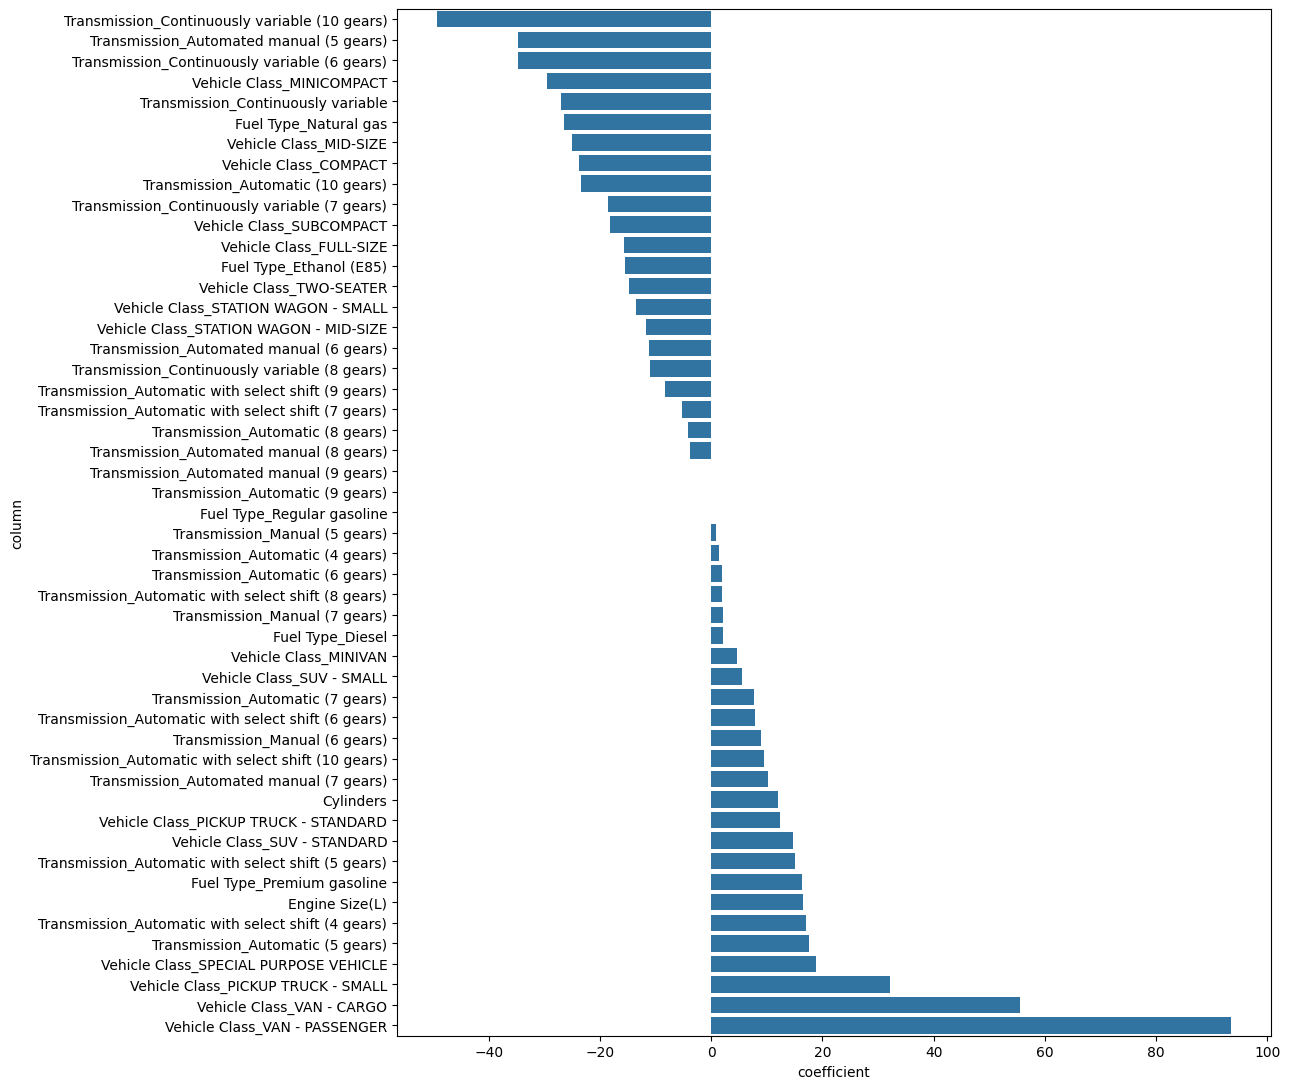

In [35]:
plt.figure(figsize=(13, 11))
sns.barplot(data=coefficients, x="coefficient", y="column")
plt.tight_layout()
plt.show()

<span style="color:#2a9d8f;"><i>
The coefficient analysis of the best-performing Lasso model (α = 0.001) reveals clear and intuitive relationships between vehicle characteristics and CO₂ emissions.  
Among the strongest positive coefficients are the following predictors:
</i></span>

<ul style="color:#2a9d8f; font-style:italic;">
  <li><b>Vehicle Class:</b> The largest positive impact comes from <b>Passenger Vans</b> (+93.46), <b>Cargo Vans</b> (+55.49), and <b>Pickup Trucks</b> (+32.10). These vehicle types are heavier, designed to carry additional load, and carry additional load most of the time, and therefore consume more fuel, resulting in higher CO₂ emissions.</li>
  <li><b>Engine Size (L)</b> (+16.53) and <b>Number of Cylinders</b> (+12.08) both have strong positive coefficients, meaning that vehicles with larger engines and more cylinders emit significantly more CO₂. This makes sense mechanically. However, number of cilinders might be not a dirrect corelator, but rather a variable very dependent on the engine volume.</li>
  <li><b>Fuel Type Z (Premium Gasoline)</b> also shows a positive coefficient (+14.09), indicating that vehicles using premium gasoline tend to have higher CO₂ emissions. This may be because such engines are tuned for higher performance, not efficiency.</li>
</ul>

<span style="color:#2a9d8f;"><i>
In contrast, several predictors show strong negative coefficients:
</i></span>

<ul style="color:#2a9d8f; font-style:italic;">
  <li><b>Transmission Type:</b> 
    Transmissions with continuous variation (<b>AV</b>, “Continuously Variable”) or automated manuals (<b>AM</b>) generally have negative coefficients (e.g., AV10: −49.36, AM5: −34.79).  
    This suggests that these systems may optimize gear ratios for smoother torque and better efficiency, resulting in reduced emissions compared to traditional automatics.
  </li>
  <li>Conversely, some standard automatic transmissions (<b>A</b> or <b>AS</b> with few gears, e.g., AS4, AS5, A5) have positive coefficients, implying they are less efficient and produce slightly higher emissions.</li>
</ul>

<b><span style="color:#2a9d8f;"><i>
✅ Conclusions:
</i></span>

<ul style="color:#2a9d8f; font-style:italic;">
  <li>Larger and heavier vehicles produce more CO₂.</li>
  <li>Higher engine displacement and cylinder count directly increase emissions.</li>
  <li>Fuel type and transmission design significantly influence efficiency — CVT and automated systems often reduce emissions, while high-performance or traditional setups tend to increase them.</li>
</ul></b>

## 7️⃣❓ <span style="color:#e63946;"><b>Create a plot to show the relationship between the independent variable with the highest-magnitude coefficient and the dependent variable. Does the visual relationship align with what you would expect from the coefficient sign and size?</b></span><br>

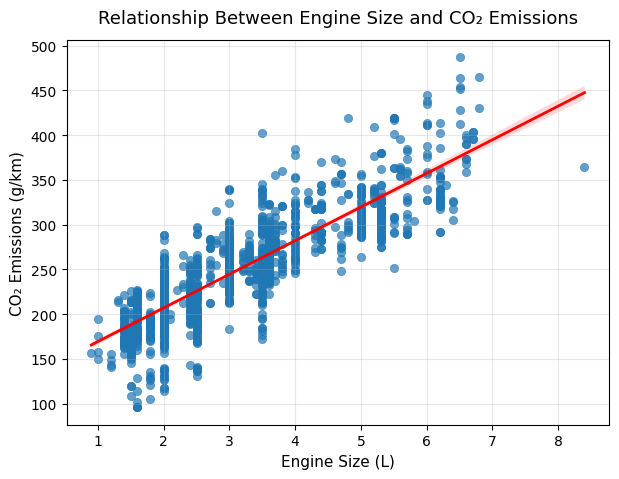

In [36]:
# Scatter plot of Engine Size
# (highest-magnitude coefficient ❗NUMERIC❗ independent variable)
# vs CO2 Emissions
plt.figure(figsize=(7,5))
sns.scatterplot(x=np.ravel(X_test["Engine Size(L)"]), y=np.ravel(y_test), alpha=0.7, edgecolor=None)
sns.regplot(x=X_test["Engine Size(L)"], y=y_test, scatter=False, color="red", line_kws={"linewidth":2})

plt.title("Relationship Between Engine Size and CO₂ Emissions", fontsize=13, pad=12)
plt.xlabel("Engine Size (L)", fontsize=11)
plt.ylabel("CO₂ Emissions (g/km)", fontsize=11)
plt.grid(alpha=0.3)
plt.show()

<span style="color:#2a9d8f;"><b><i>
The independent variable with the highest-magnitude coefficient in the Lasso model is <b>Engine Size (L)</b>, with a coefficient of +16.53.  
This indicates a strong positive linear relationship with CO₂ emissions - as the engine size increases, CO₂ emissions also increase. This plot's visual relationship align well with what I would expect from the coefficient sign and size</i></b></span>

## 8️⃣❓ <span style="color:#e63946;"><b>Based on your findings, discuss whether you would recommend using your best-performing Lasso model for future predictions.</b></span><br>

#### <span style="color:#2a9d8f;"><b>✅ Yes, the best-performing Lasso model (α = 0.001) demonstrates strong generalization with similar Train and Test R² scores and a low RMSE, indicating reliable predictive performance suitable for future CO₂ emission estimations.</b></span>